In [1]:
import mediapipe as mp
from mediapipe.tasks.python import vision
import cv2 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
from multiprocessing.pool import ThreadPool as Pool
from gc import collect
from mediapipe.python.solutions.drawing_utils import DrawingSpec
import math

from matplotlib import pyplot as plt
from src.video_utils import read_video

In [2]:
video, timestamps = read_video('../../../Datasets/AUTSL/test/signer6_sample1_color.mp4')
video.shape

(55, 512, 512, 3)

In [3]:
BaseOptions = mp.tasks.BaseOptions
VisionRunningMode = mp.tasks.vision.RunningMode

PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions

HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions

In [4]:
# Create a pose landmarker instance with the video mode:
POSE_OPTIONS = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='mediapipe_models/pose_landmarker_heavy.task'),
    running_mode=VisionRunningMode.VIDEO)

# Create a hand landmarker instance with the video mode:
HAND_OPTIONS = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='mediapipe_models/hand_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=4
)

POSE_HAND_BASIS = {'Left':  np.array([15, 17, 19, 21]),
                    'Right': np.array([16, 18, 20, 22])}
HAND_BASIS = np.array([0, 17, 5, 1])

def get_skeleton_edges():
    del_mask = (np.arange(75) >= 15) & (np.arange(75) <= 22)  # True if point deleted
    pose_edges = mp.solutions.pose.POSE_CONNECTIONS
    hand_edges = mp.solutions.hands.HAND_CONNECTIONS
    edges = []
    for (u, v) in pose_edges:
        if del_mask[u] or del_mask[v]:
            continue
        edges.append((u, v))
    for (u, v) in hand_edges:
        edges.append((u + 33, v + 33))
        edges.append((u + 54, v + 54))
    edges.append((13, 33))
    edges.append((14, 54))
    return frozenset(edges)


SKELETON_EDGES = get_skeleton_edges()

FRAME_SHAPE = np.array(video.shape[1:3])

np.random.seed(2312)
EDGE_COLORS = tuple(tuple(int(i) for i in np.random.randint(10, 246, 3))
                    for e in SKELETON_EDGES)

In [5]:
def detect_pose(video, timestamps):
    cnt_frames = len(video)
    with PoseLandmarker.create_from_options(POSE_OPTIONS) as pose_model:
        res = []
        for frame, timestamp in zip(video, timestamps):
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
            res.append(pose_model.detect_for_video(mp_image, timestamp))

        pose_points = np.empty((cnt_frames, 33, 2)) + np.nan
        for i, frame_res in enumerate(res):
            if len(frame_res.pose_landmarks) == 0:
                continue
            pose_points[i] = np.array([
                [lm.x, lm.y] for lm in frame_res.pose_landmarks[0]
            ])
    return pose_points


def detect_all_hands(video, timestamps):
    cnt_frames = len(video)
    with HandLandmarker.create_from_options(HAND_OPTIONS) as hand_model:
        res = []
        for frame, timestamp in zip(video, timestamps):
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
            res.append(hand_model.detect_for_video(mp_image, timestamp))

        hands = [{'Left': [], 'Right':[]}
                 for i in range(cnt_frames)]
        
        for i, frame_res in enumerate(res):
            if len(frame_res.handedness) == 0:
                continue
            for hand_index, hand_info in enumerate(frame_res.handedness):
                hands[i][hand_info[0].category_name].append(
                    np.array([
                        [lm.x, lm.y]
                        for lm in frame_res.hand_landmarks[hand_index]
                    ])
                )
            
            # unmirror image
            hands[i]['Left'], hands[i]['Right'] = hands[i]['Right'], hands[i]['Left']
            
    return hands


def match_distance(pose_hand_points, hand_points):
    return ((pose_hand_points - hand_points)**2).sum(axis=-1).mean()


def match_hands(pose_points, all_hands_points):
    hand_points_shape = (pose_points.shape[0], 21, 2)
    hand_points = {
        'Left': np.empty(hand_points_shape) + np.nan,
        'Right': np.empty(hand_points_shape) + np.nan
    }
    

    for i, (pose, hand_group) in enumerate(zip(pose_points, all_hands_points)):
        for side in hand_points:
            if len(hand_group[side]) > 0:
                d = np.array([
                    match_distance(pose[POSE_HAND_BASIS[side]], hand[HAND_BASIS])
                    for hand in hand_group[side]
                ])

                # if all hand are on large distance, leave nan?
                # print(i, np.round(d.min(), decimals=7))
                if d.min() < 0.01:
                    index = d.argmin()
                    hand_points[side][i] = hand_group[side][index]
            
            # if hand is not detected, leave pose hand keypoints
            if np.isnan(hand_points[side][i]).all():
                hand_points[side][i][HAND_BASIS] = pose[POSE_HAND_BASIS[side]]
                
    return hand_points


def detect_skeleton_points(video, timestamps):
    # If video frames have different width and heights, video is padded by zeros
    if video.shape[1] != video.shape[2]:
        longest_side = max(video.shape[1:3])
        new_shape = (video.shape[0], longest_side, longest_side, *video.shape[3:])
        new_video = np.zeros(new_shape, dtype=video.dtype)
        pos = tuple(((new_side - old_side) // 2, (new_side - old_side) // 2 + old_side)
                    for old_side, new_side in zip(video.shape[1:3], new_shape[1:3]))
        new_video[:, pos[0][0]: pos[0][1], pos[1][0]: pos[1][1]] = video
        video = new_video
        
    pose_points = detect_pose(video, timestamps)
    all_hands_points = detect_all_hands(video, timestamps)
    hands_points = match_hands(pose_points, all_hands_points)

    skeleton_points = np.concatenate(
        (pose_points, hands_points['Left'], hands_points['Right']),
        axis=1
    )
    return skeleton_points

In [6]:
def draw_skeleton(skeleton):
    frame = np.zeros((*FRAME_SHAPE, 3), dtype=np.uint8)
    for (u, v), color in zip(SKELETON_EDGES, EDGE_COLORS):
        if np.isnan(skeleton[u]).any() or np.isnan(skeleton[v]).any(): 
            continue
        
        frame = cv2.line(frame,
                         np.round(skeleton[u] * FRAME_SHAPE).astype(np.int32),
                         np.round(skeleton[v] * FRAME_SHAPE).astype(np.int32),
                         color,
                         1)
    return frame

In [7]:
skel = detect_skeleton_points(video[:, :, 100:-100], timestamps)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


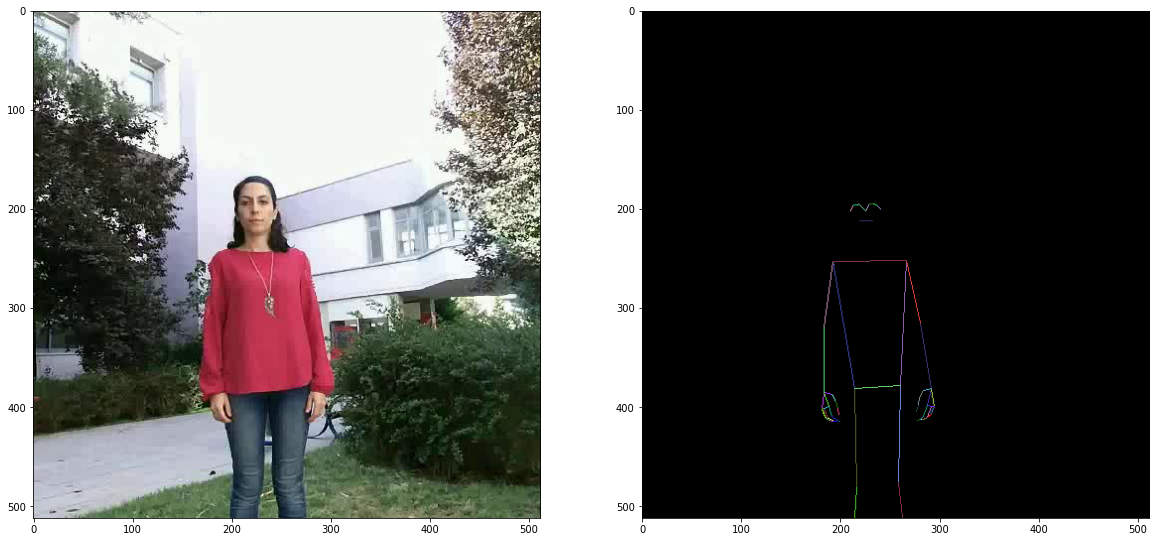

In [8]:
for frame, sk in zip(video, skel):
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(frame)
    plt.subplot(1,2,2)
    plt.imshow(draw_skeleton(sk))
    plt.show()
    break

In [9]:
def process_path(video_path):
    return video_path, detect_skeleton_points(*read_video(video_path))

def extract_skeletons_for_videos(path_to_videos):
    skeleton_mapper = {}
    try:
        all_video_paths = (os.path.join(path_to_videos, video_name) for video_name in os.listdir(path_to_videos))
        with Pool() as pool:
            for video_path, skeleton in tqdm(pool.imap(process_path, all_video_paths), total=len(os.listdir(path_to_videos))):
                skeleton_mapper[video_path] = skeleton
    except KeyboardInterrupt:
        pass
    
    return skeleton_mapper

In [10]:
path_to_videos = '../../Datasets/AUTSL/test/'
# res = extract_skeletons_for_videos(path_to_videos)

In [11]:
def get_default_skeleton_style():
    
    def is_pose_landmark(idx):
        return (0 <= idx) & (idx < 33)
    
    def is_left_hand_landmark(idx):
        return (33 <= idx) & (idx < 54)
    
    def is_right_hand_landmark(idx):
        return (54 <= idx) & (idx < 75) 
    
    pose_landmarks_style = mp.solutions.drawing_styles.get_default_pose_landmarks_style()    
    hand_landmarks_style = mp.solutions.drawing_styles.get_default_hand_landmarks_style()
    for k in hand_landmarks_style:
        hand_landmarks_style[k].circle_radius = 1
        hand_landmarks_style[k].thickness = 2

    pose_connections_style = mp.solutions.drawing_styles.DrawingSpec()
    hand_connections_style = mp.solutions.drawing_styles.get_default_hand_connections_style()
    
    
    landmarks_style = dict()
    for i in range(75):
        if is_pose_landmark(i):
            landmarks_style[i] = pose_landmarks_style[i]
        elif is_left_hand_landmark(i):
            landmarks_style[i] = hand_landmarks_style[i - 33]
        elif is_right_hand_landmark(i):
            landmarks_style[i] = hand_landmarks_style[i - 54]
        else:
            raise ValueError(f"Got wrong landmark index: {i}")
    
    connections_style = dict()
    for edge in SKELETON_EDGES:
        np_edge = np.array(edge, dtype=np.int32)
        if is_pose_landmark(np_edge).any():
            connections_style[edge] = pose_connections_style
        elif is_left_hand_landmark(np_edge).all():
            connections_style[edge] = hand_connections_style[tuple(np_edge - 33)]
        elif is_right_hand_landmark(np_edge).all():
            connections_style[edge] = hand_connections_style[tuple(np_edge - 54)]
        else:
            raise ValueError(f"Got wrong connection: {edge}")
    
    return landmarks_style, connections_style

SKELETON_LANDMARKS_STYLE, SKELETON_CONNECTIONS_STYLE = get_default_skeleton_style()

In [16]:
def draw_landmarks(
    image, 
    landmarks, 
    connections=SKELETON_EDGES, 
    landmarks_style=SKELETON_LANDMARKS_STYLE, 
    connections_style=SKELETON_CONNECTIONS_STYLE):

    image_scale = np.array(image.shape[1::-1])
    landmarks = np.round(landmarks.copy() * image_scale).astype(np.int32)
    
    for connection in connections:
        start_idx = connection[0]
        end_idx = connection[1]
        drawing_spec = connections_style[connection]
        cv2.line(image, landmarks[start_idx],
                 landmarks[end_idx], drawing_spec.color,
                 drawing_spec.thickness)    
    
    for idx in set(v for edge in connections for v in edge):
        drawing_spec = landmarks_style[idx]
        
        # White circle border
        circle_border_radius = max(drawing_spec.circle_radius + 1,
                                 int(drawing_spec.circle_radius * 1.2))
        cv2.circle(image, landmarks[idx], circle_border_radius, (224, 224, 224),
                 drawing_spec.thickness)
        # Fill color into the circle
        cv2.circle(image, landmarks[idx], drawing_spec.circle_radius,
                 drawing_spec.color, drawing_spec.thickness)
        
    return image

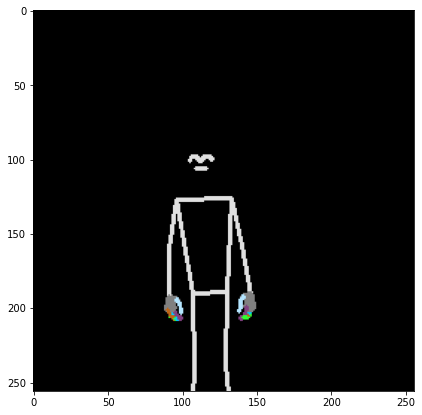

In [17]:
img = draw_landmarks(np.zeros((256, 256, 3), dtype=np.uint8), sk)
plt.figure(figsize=(7,7))
plt.imshow(img)